In [12]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_apd as dr_a
import tools.data_reader_ascertain as dr_asc
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

# model_phases_apd = [
#     [
#         "Baseline_Rest", 
#         "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
#         "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
#     ]
# ]

model_phases_apd = [
    "Baseline_Rest", 
    "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
    "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
]

# anxiety_label_type = "Anxiety"
anxiety_label_type = None
asc_label_type = dr_asc.SelfReports.AROUSAL

models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

threshold = "fixed"
asc_threshold = "fixed"
test_size = 1.0

temp_a, _ = train.Train_APD.get_apd_data_ranking([train.Metrics.BPM], phases=dr_a.Phases.PHASES_LIST)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_apd_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_apd_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))


Error in generating lf_hf_ratio


APD PHASES ['Baseline_Rest', 'BugBox_Relax', 'BugBox_Anticipate', 'BugBox_Exposure', 'BugBox_Break', 'Speech_Relax', 'Speech_Anticipate', 'Speech_Exposure', 'Speech_Break'] --------------------------------------------------
Ratio of positive to negative labels (0.2857142857142857) is under 0.333, oversampling positive class.
Ratio of negative to positive labels (0.1721419185282523) is under 0.333, oversampling negative class.
y_train:
0    315
1    104
Name: label, dtype: int64
y_test:
1    1522
0     506
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [2026    2]
Calculating shap values
Model RF, Predictions: [0 1], [1979   49]
Calculating shap values
Model XGB, Predictions: [0 1], [1883  145]
Calculating shap values
[[ 0.15572439  0.07856698  0.7803541   1.21942697  0.32487813  0.90036686
  -0.34406216  1.60388126]]
[0.13113581 0.11393623 0.11800876 0.1332387  0.10288884 0.13756397
 0.13038778 0.1328399 ]


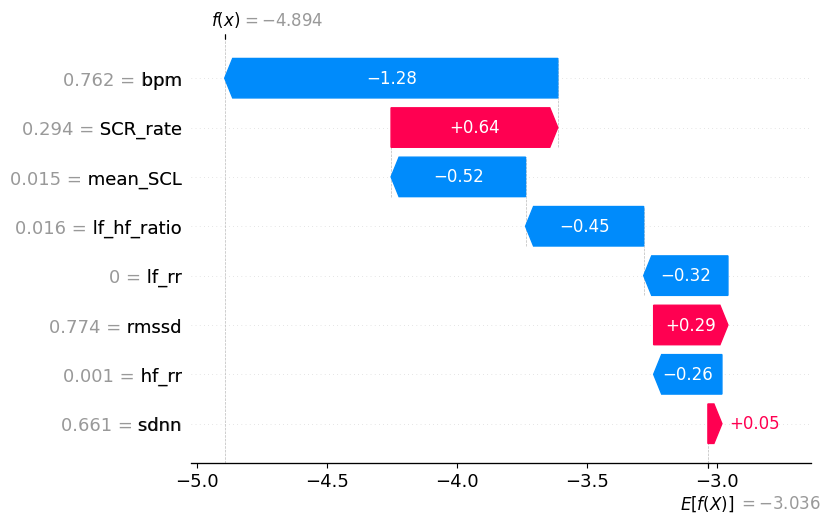

LogReg accuracy over 1 rounds: 0.2504930966469428
RF accuracy over 1 rounds: 0.2588757396449704
XGB accuracy over 1 rounds: 0.28155818540433925




In [18]:
# TRAIN ON APD AND TEST ON ASCERTAIN
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_asc)
importlib.reload(dt)


print(f"APD PHASES {model_phases_apd} " + "-"*50)
x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_ASCERTAIN.get_ascertain_data(metrics, verbose=False, label_type=asc_label_type, threshold=asc_threshold, normalize=True)
# drop subjects with noisy data
x_a = x_a[~x_a["subject"].isin(invalid_apd_subjects)]
y_a = y_a[~y_a["subject"].isin(invalid_apd_subjects)]
inds = pd.isnull(x_b).any(axis=1).to_numpy().nonzero()[0]
x_b = x_b.drop(labels=inds, axis=0)
y_b = y_b.drop(labels=inds, axis=0)

if anxiety_label_type is not None:
    x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, save_metrics=True, test_size=test_size, is_resample=True, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.5:
        print(f"Model evaluation metrics for {model_name}:")
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"\tPrecision: {p}\n\tRecall: {r}\n\tF1-score: {f1}\n\tAUC score: {auc}")
print("\n")

In [ ]:
importlib.reload(train)
importlib.reload(dr_a)

ha, la = train.Train_APD.get_ratings(phases=model_phases_apd, threshold=threshold)
ha = ha[~ha["subject"].isin(invalid_apd_subjects)]
la = la[~la["subject"].isin(invalid_apd_subjects)]
print(ha)
print(la)

# x, y = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold)
# x = x[~x["subject"].isin(invalid_apd_subjects)]
# y = y[~y["subject"].isin(invalid_apd_subjects)]
# for i in range(y.shape[0] // 52):
#     print(y.iloc[i*52:i*52+52, :])

Ratio of negative to positive labels (0.1721419185282523) is under 0.333, oversampling negative class.
Ratio of positive to negative labels (0.2857142857142857) is under 0.333, oversampling positive class.
y_train:
1    1522
0     506
Name: label, dtype: int64
y_test:
0    315
1    104
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [ 54 365]
Calculating shap values
Model RF, Predictions: [0 1], [ 40 379]
Calculating shap values
Model XGB, Predictions: [0 1], [ 56 363]
Calculating shap values
[[ 0.2439693  -1.54825984  0.09265466  1.027773   -1.138831   -1.60406764
   0.78477142 -0.3944496 ]]
[0.13473    0.1505031  0.11193094 0.11698021 0.14912421 0.09836548
 0.10265199 0.13571407]


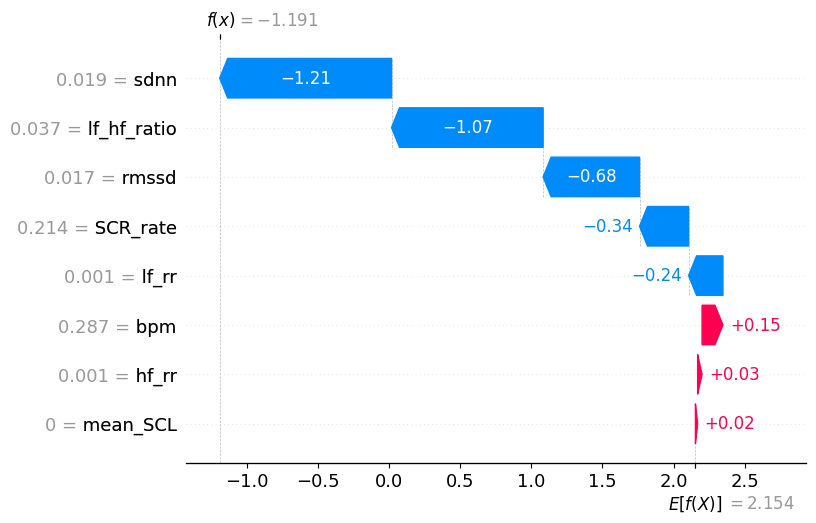

LogReg accuracy over 1 rounds: 0.2863961813842482
	Report:
	Precision: 0.2328767123287671
	Recall: 0.8173076923076923
	F1-score: 0.3624733475479744
	AUC score: 0.4642094017094017
RF accuracy over 1 rounds: 0.31026252983293556
	Report:
	Precision: 0.2559366754617414
	Recall: 0.9326923076923077
	F1-score: 0.40165631469979296
	AUC score: 0.5187271062271062
XGB accuracy over 1 rounds: 0.315035799522673
	Report:
	Precision: 0.24793388429752067
	Recall: 0.8653846153846154
	F1-score: 0.38543897216274087
	AUC score: 0.49935897435897436




In [21]:
# TRAIN ON ASCERTAIN AND TEST ON APD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_asc)
importlib.reload(dt)


# for j, phases_apd in enumerate(model_phases_apd):
#     print(f"APD PHASES {phases_apd} " + "-"*50)
#     phases_apd = [phases_apd]
x_a, y_a = train.Train_ASCERTAIN.get_ascertain_data(metrics, verbose=False, label_type=asc_label_type, threshold=asc_threshold, normalize=True)
# x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
# drop subjects with noisy data
x_b = x_b[~x_b["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_b = y_b[~y_b["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
inds = pd.isnull(x_a).any(axis=1).to_numpy().nonzero()[0]
x_a = x_a.drop(labels=inds, axis=0).reset_index(drop=True)
y_a = y_a.drop(labels=inds, axis=0).reset_index(drop=True)

if anxiety_label_type is not None:
    x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, save_metrics=True, test_size=test_size, is_resample=True, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.0:
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"\tReport:\n\tPrecision: {p}\n\tRecall: {r}\n\tF1-score: {f1}\n\tAUC score: {auc}")
print("\n")